### Идентификация марковских моделей с помощью анализа последовательностей, по которым генерируются стохастические матрицы  

Имеем следующие классы стохастических матриц:  

1) Положительные  
2) Дважды стохастические  
3) С локальными вероятностными переходами  
4) Квазитреугольные (верхние и нижние)  
5) Блочно-сообщающиеся (правые и левые)  
6) Разреженные с энтропией, равной 0,2; 0,4; 0,6  

Импортируем необходимые библиотеки:

In [32]:
import openpyxl
from openpyxl.writer.excel import save_workbook
import numpy as np
import pandas as pd
import quantecon as qe
import math
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsOneClassifier
from pycaret.regression import *
from pycaret.classification import *
from pycaret.clustering import *
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.multiclass import OutputCodeClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import np_utils
from sklearn.metrics import accuracy_score
import time
from matplotlib import pyplot as plt   
from sklearn.preprocessing import MinMaxScaler

Метод генерации матриц по последовательностям

In [2]:
def transition_matrix(transitions):
    n = 1 + max(transitions)
    M = [[0]*n for _ in range(n)]
    
    for (i,j) in zip(transitions,transitions[1:]):
        M[i][j] += 1
        
    for row in M:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    return M

Берем по одной матрице из каждого класса, генерируем новые матрицы и новые последовательности

In [46]:
# сюда вставляем по додной матрице из каждого класса
matrix = np.array([
    [0.000, 0.000, 0.641, 0.147, 0.212],
    [0.000, 0.000, 0.196, 0.484, 0.320],
    [0.000, 0.000, 0.017, 0.385, 0.598],
    [0.544, 0.456, 0.000, 0.000, 0.000],
    [0.499, 0.501, 0.000, 0.000, 0.000]])
list_m = []
list_l = []

for i in range(0, 100):
    mc = qe.MarkovChain(matrix)
    k = mc.simulate(100, init=0)
    list_l.append(k)
    m = transition_matrix(k)
    list_m.append(m)

Инициализируем массивы ответов и словарь частот встречаемости значений разности 

In [47]:
ar = []
res = []
d = {-4:0,-3:0,-2:0,-1:0,0:0,1:0,2:0,3:0,4:0}

Считаем частоты стречаемых значений разности между первым и вторым элементом

In [48]:
for el in list_l:
    for i in range(1, len(el)):
        difference = el[i] - el[i-1]
        d[difference] = d[difference] + 1
    for val in d.values():
        ar.append(val)
    res.append(ar)
    ar = []
    d = {-4:0,-3:0,-2:0,-1:0,0:0,1:0,2:0,3:0,4:0}

Значения поля target: P положит(резк) - 0, Бп - 1, Р положит(плав) - 2, Д - 3, ЛП - 4, Н_20 - 5, Н_40 - 6, Н_60 - 7, Тв - 8, Тн - 9, Бл - 10. Собираем все данные в xlsx файл, меняя параметры c1, с2, с3 для записи в ячейки.

In [49]:
c1 = 1001
c2 = 7001
c3 = 1002

wb = openpyxl.load_workbook('Sequence_properties.xlsx')  
ws1 = wb.get_sheet_by_name('Лист1')
row = c1  
column = 1
for ar in list_l:
    for el in ar:
        ws1.cell(column=column, row=row).value = el
        row = row + 1
    column = column + 1
    row = c1

ws2 = wb.get_sheet_by_name('Matrix')
row = c2   
column = 1
for mat in list_m:
    for ar in mat:
        for el in ar:
            ws2.cell(column=column, row=row).value = el
            column = column + 1
        row = row + 1
        column = 1
    row = row + 2 

ws3 = wb.get_sheet_by_name('Properties')
row = c3   
column = 1
for ar in res:
    for el in ar:
        ws3.cell(column=column, row=row).value = el
        column = column + 1
    row = row + 1
    column = 1    

save_workbook(wb, 'Sequence_properties.xlsx')

True

In [45]:
data = pd.read_excel("Sequence_properties.xlsx", "Properties")
data.head(10)

,-4,-3,-2,-1,0,1,2,3,4,target
0,3,4,0,1,83,1,0,3,4,0
1,2,6,1,1,78,1,1,6,3,0
2,5,3,0,2,79,1,0,2,7,0
3,4,4,0,1,80,1,0,4,5,0
4,4,6,0,2,74,2,0,6,5,0
5,7,2,1,3,72,3,0,4,7,0
6,4,4,0,2,77,3,0,5,4,0
7,4,6,0,0,77,1,0,7,4,0
8,4,6,0,0,78,0,0,6,5,0
9,3,7,0,1,76,1,0,7,4,0


По опыту работы с параметрами, вычисляемыми по матрицам, строим модели многоклассовой классификации для определения, к какому классу относятся полученные значения, вычисленные по последовательностям

In [46]:
X = data.drop(['target'], axis=1)
Y = data['target']

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

In [6]:
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, Y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=42)

In [7]:
y_pred = classifier.predict(X_test)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00        25
           2       0.86      0.97      0.91        31
           3       1.00      0.94      0.97        35
           4       1.00      1.00      1.00        28
           5       0.97      0.92      0.94        37
           6       1.00      1.00      1.00        28
           7       1.00      1.00      1.00        34
           8       1.00      1.00      1.00        29
           9       1.00      1.00      1.00        27
          10       1.00      1.00      1.00        23

    accuracy                           0.98       330
   macro avg       0.98      0.98      0.98       330
weighted avg       0.98      0.98      0.98       330



In [8]:
pred_proba = OneVsRestClassifier(LinearSVC(random_state=0)).fit(X_train, Y_train).predict(X_test)
print(classification_report(Y_test, pred_proba))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        33
           1       1.00      1.00      1.00        25
           2       0.93      0.84      0.88        31
           3       0.88      1.00      0.93        35
           4       1.00      1.00      1.00        28
           5       0.97      0.95      0.96        37
           6       1.00      1.00      1.00        28
           7       1.00      0.97      0.99        34
           8       0.97      1.00      0.98        29
           9       1.00      1.00      1.00        27
          10       1.00      1.00      1.00        23

    accuracy                           0.97       330
   macro avg       0.98      0.97      0.98       330
weighted avg       0.97      0.97      0.97       330



In [9]:
pred_proba = OneVsOneClassifier(LinearSVC(random_state=0)).fit(X_train, Y_train).predict(X_test)
print(classification_report(Y_test, pred_proba))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00        25
           2       0.90      0.87      0.89        31
           3       0.97      1.00      0.99        35
           4       1.00      1.00      1.00        28
           5       0.92      0.92      0.92        37
           6       1.00      1.00      1.00        28
           7       1.00      1.00      1.00        34
           8       1.00      1.00      1.00        29
           9       1.00      1.00      1.00        27
          10       1.00      1.00      1.00        23

    accuracy                           0.98       330
   macro avg       0.98      0.98      0.98       330
weighted avg       0.98      0.98      0.98       330



In [12]:
pred_proba = OutputCodeClassifier(LinearSVC(random_state=0), code_size=2, random_state=0).fit(X_train, Y_train).predict(X_test)
print(classification_report(Y_test, pred_proba))

              precision    recall  f1-score   support

           0       1.00      0.88      0.94        33
           1       1.00      0.96      0.98        25
           2       0.70      0.74      0.72        31
           3       0.90      0.80      0.85        35
           4       0.97      1.00      0.98        28
           5       0.97      0.84      0.90        37
           6       0.93      0.89      0.91        28
           7       1.00      1.00      1.00        34
           8       0.76      1.00      0.87        29
           9       1.00      1.00      1.00        27
          10       0.88      1.00      0.94        23

    accuracy                           0.91       330
   macro avg       0.92      0.92      0.92       330
weighted avg       0.92      0.91      0.91       330



In [47]:
def neural_network():
    model = Sequential()
    model.add(Dense(9, input_dim=9, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(9))
    model.add(Dense(11, activation='sigmoid'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [48]:
dummy_y = np_utils.to_categorical(Y)

In [49]:
d_of_values = {}
count = len(X.columns.tolist())

for i in range(0, count):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(np.array(X.iloc[:,i]).reshape(-1, 1))
    scaled_data = scaled_data.reshape(len(scaled_data))
    d_of_values[data.columns.tolist()[i]] = scaled_data
    
x = pd.DataFrame(d_of_values)
x

,-4,-3,-2,-1,0,1,2,3,4
0,0.157895,0.133333,0.000000,0.027027,0.943182,0.025,0.000000,0.157895,0.129032
1,0.105263,0.200000,0.028571,0.027027,0.886364,0.025,0.022222,0.315789,0.096774
2,0.263158,0.100000,0.000000,0.054054,0.897727,0.025,0.000000,0.105263,0.225806
3,0.210526,0.133333,0.000000,0.027027,0.909091,0.025,0.000000,0.210526,0.161290
4,0.210526,0.200000,0.000000,0.054054,0.840909,0.050,0.000000,0.315789,0.161290
...,...,...,...,...,...,...,...,...,...
1095,0.421053,0.700000,0.314286,0.000000,0.000000,0.250,0.888889,0.368421,0.064516
1096,0.473684,0.766667,0.257143,0.000000,0.000000,0.300,0.711111,0.421053,0.193548
1097,0.368421,0.633333,0.428571,0.000000,0.000000,0.350,0.622222,0.789474,0.032258
1098,0.526316,0.733333,0.314286,0.000000,0.000000,0.250,0.622222,0.526316,0.258065


In [50]:
X_train, X_test, Y_train, Y_test = train_test_split(x, dummy_y, test_size = 0.3, random_state = 42)

In [110]:
start_time = time.time()
model = neural_network()
model.fit(X_train, Y_train, batch_size=7, epochs=100, verbose=1)
 
predictions = model.predict_proba(X_test).argmax(axis=1)
t = time.time() - start_time

Epoch 1/100
110/110 [==============================] - 0s 984us/step - loss: 2.3214 - accuracy: 0.1636
Epoch 2/100
110/110 [==============================] - 0s 855us/step - loss: 2.1817 - accuracy: 0.3701
Epoch 3/100
110/110 [==============================] - 0s 802us/step - loss: 2.0494 - accuracy: 0.4896
Epoch 4/100
110/110 [==============================] - 0s 768us/step - loss: 1.9175 - accuracy: 0.4818
Epoch 5/100
110/110 [==============================] - 0s 891us/step - loss: 1.7899 - accuracy: 0.4701
Epoch 6/100
110/110 [==============================] - 0s 855us/step - loss: 1.5910 - accuracy: 0.4701
Epoch 7/100
110/110 [==============================] - 0s 851us/step - loss: 1.3953 - accuracy: 0.4701
Epoch 8/100
110/110 [==============================] - 0s 993us/step - loss: 1.1339 - accuracy: 0.6390
Epoch 9/100
110/110 [==============================] - 0s 775us/step - loss: 0.9632 - accuracy: 0.6571
Epoch 10/100
110/110 [==============================] - 0s 900us/step - l

110/110 [==============================] - 0s 973us/step - loss: 0.2751 - accuracy: 0.9013
Epoch 81/100
110/110 [==============================] - 0s 818us/step - loss: 0.2902 - accuracy: 0.8883
Epoch 82/100
110/110 [==============================] - 0s 1ms/step - loss: 0.3307 - accuracy: 0.8779
Epoch 83/100
110/110 [==============================] - 0s 957us/step - loss: 0.2696 - accuracy: 0.8909
Epoch 84/100
110/110 [==============================] - 0s 864us/step - loss: 0.2610 - accuracy: 0.8922
Epoch 85/100
110/110 [==============================] - 0s 964us/step - loss: 0.2538 - accuracy: 0.9117
Epoch 86/100
110/110 [==============================] - 0s 1ms/step - loss: 0.2334 - accuracy: 0.9260
Epoch 87/100
110/110 [==============================] - 0s 1ms/step - loss: 0.2413 - accuracy: 0.9078
Epoch 88/100
110/110 [==============================] - 0s 864us/step - loss: 0.2380 - accuracy: 0.9000
Epoch 89/100
110/110 [==============================] - 0s 900us/step - loss: 0.245

In [52]:
dummy_pred = np_utils.to_categorical(predictions)

In [53]:
print(classification_report(Y_test, dummy_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      0.96      0.98        25
           2       0.90      0.87      0.89        31
           3       0.97      1.00      0.99        35
           4       0.97      1.00      0.98        28
           5       0.92      0.92      0.92        37
           6       1.00      1.00      1.00        28
           7       1.00      1.00      1.00        34
           8       1.00      1.00      1.00        29
           9       1.00      1.00      1.00        27
          10       1.00      1.00      1.00        23

   micro avg       0.98      0.98      0.98       330
   macro avg       0.98      0.98      0.98       330
weighted avg       0.98      0.98      0.98       330
 samples avg       0.98      0.98      0.98       330



In [54]:
print(f'Accuracy:{accuracy_score(Y_test, dummy_pred)}')

Accuracy:0.9757575757575757


In [55]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 9)                 90        
_________________________________________________________________
dropout_4 (Dropout)          (None, 9)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 9)                 90        
_________________________________________________________________
dense_11 (Dense)             (None, 11)                110       
Total params: 290
Trainable params: 290
Non-trainable params: 0
_________________________________________________________________


In [111]:
t

11.151853084564209

Для дальнейшей работы исходя из результатов выберем модель нейронной сети, которая на 100 данных показывает время работы, выведенное выше. Соберем новые датасеты для последовательностей разных длин: 50, 500, 1000, 5000.

In [26]:
matrix = np.array([
    [0.023246059, 0.005601748, 0.046717988, 0.066559277, 0.857874927],
    [0.013646387, 0.049058382, 0.016698736, 0.129693725, 0.79090277],
    [0.04620738, 0.001635162, 0.012218447, 0.008067163, 0.931871848],
    [0.06745643, 0.118393449, 0.09455569, 0.028992576, 0.690601853],
    [0.071950483, 0.2378727, 0.137118006, 0.039143621, 0.513915191]])
list_m = []
list_l = []

for i in range(0, 100):
    mc = qe.MarkovChain(matrix)
    k = mc.simulate(50, init=0)
    list_l.append(k)
    m = transition_matrix(k)
    list_m.append(m)
    
ar = []
res = []
d = {-4:0,-3:0,-2:0,-1:0,0:0,1:0,2:0,3:0,4:0}

for el in list_l:
    for i in range(1, len(el)):
        difference = el[i] - el[i-1]
        d[difference] = d[difference] + 1
    for val in d.values():
        ar.append(val)
    res.append(ar)
    ar = []
    d = {-4:0,-3:0,-2:0,-1:0,0:0,1:0,2:0,3:0,4:0}
    
c1 = 1
c2 = 2

wb = openpyxl.load_workbook('50.xlsx')  
ws1 = wb.get_sheet_by_name('Лист1')
row = c1  
column = 1
for ar in list_l:
    for el in ar:
        ws1.cell(column=column, row=row).value = el
        row = row + 1
    column = column + 1
    row = c1

ws2 = wb.get_sheet_by_name('Properties')
row = c2  
column = 1
for ar in res:
    for el in ar:
        ws2.cell(column=column, row=row).value = el
        column = column + 1
    row = row + 1
    column = 1    

save_workbook(wb, '50.xlsx')

True

In [27]:
matrix = np.array([
    [0.455, 0.545, 0.000, 0.000, 0.000],
    [0.223, 0.609, 0.168, 0.000, 0.000],
    [0.000, 0.279, 0.429, 0.191, 0.101],
    [0.000, 0.000, 0.406, 0.384, 0.210],
    [0.000, 0.000, 0.495, 0.315, 0.190]])
list_m = []
list_l = []

for i in range(0, 100):
    mc = qe.MarkovChain(matrix)
    k = mc.simulate(50, init=0)
    list_l.append(k)
    m = transition_matrix(k)
    list_m.append(m)
    
ar = []
res = []
d = {-4:0,-3:0,-2:0,-1:0,0:0,1:0,2:0,3:0,4:0}

for el in list_l:
    for i in range(1, len(el)):
        difference = el[i] - el[i-1]
        d[difference] = d[difference] + 1
    for val in d.values():
        ar.append(val)
    res.append(ar)
    ar = []
    d = {-4:0,-3:0,-2:0,-1:0,0:0,1:0,2:0,3:0,4:0}
    
c1 = 51
c2 = 102

wb = openpyxl.load_workbook('50.xlsx')  
ws1 = wb.get_sheet_by_name('Лист1')
row = c1  
column = 1
for ar in list_l:
    for el in ar:
        ws1.cell(column=column, row=row).value = el
        row = row + 1
    column = column + 1
    row = c1

ws2 = wb.get_sheet_by_name('Properties')
row = c2  
column = 1
for ar in res:
    for el in ar:
        ws2.cell(column=column, row=row).value = el
        column = column + 1
    row = row + 1
    column = 1    

save_workbook(wb, '50.xlsx')

True

In [28]:
matrix = np.array([
    [0.210320514, 0.274879198, 0.119375148, 0.320626736, 0.074798404],
    [0.085808181, 0.258198181, 0.331194188, 0.30701685, 0.0177826],
    [0.098470341, 0.295037295, 0.159363517, 0.254503354, 0.192625493],
    [0.137239473, 0.342470158, 0.308467346, 0.176949439, 0.034873585],
    [0.414134897, 0.317554959, 0.061405659, 0.006018718, 0.200885768]
])
list_m = []
list_l = []

for i in range(0, 100):
    mc = qe.MarkovChain(matrix)
    k = mc.simulate(50, init=0)
    list_l.append(k)
    m = transition_matrix(k)
    list_m.append(m)
    
ar = []
res = []
d = {-4:0,-3:0,-2:0,-1:0,0:0,1:0,2:0,3:0,4:0}

for el in list_l:
    for i in range(1, len(el)):
        difference = el[i] - el[i-1]
        d[difference] = d[difference] + 1
    for val in d.values():
        ar.append(val)
    res.append(ar)
    ar = []
    d = {-4:0,-3:0,-2:0,-1:0,0:0,1:0,2:0,3:0,4:0}
    
c1 = 101
c2 = 202

wb = openpyxl.load_workbook('50.xlsx')  
ws1 = wb.get_sheet_by_name('Лист1')
row = c1  
column = 1
for ar in list_l:
    for el in ar:
        ws1.cell(column=column, row=row).value = el
        row = row + 1
    column = column + 1
    row = c1

ws2 = wb.get_sheet_by_name('Properties')
row = c2  
column = 1
for ar in res:
    for el in ar:
        ws2.cell(column=column, row=row).value = el
        column = column + 1
    row = row + 1
    column = 1    

save_workbook(wb, '50.xlsx')

True

In [29]:
matrix = np.array([
    [0.198964414, 0.260941274, 0.062515519, 0.313602016, 0.163976777],
    [0.094098288, 0.242054193, 0.319600366, 0.155162279, 0.189084874],
    [0.281606257, 0.23585606, 0.001, 0.209688285, 0.271849398],
    [0.170857902, 0.140203238, 0.326095823, 0.162519882, 0.200323156],
    [0.254473139, 0.120945235, 0.290788292, 0.159027538, 0.174765796]])
list_m = []
list_l = []

for i in range(0, 100):
    mc = qe.MarkovChain(matrix)
    k = mc.simulate(50, init=0)
    list_l.append(k)
    m = transition_matrix(k)
    list_m.append(m)
    
ar = []
res = []
d = {-4:0,-3:0,-2:0,-1:0,0:0,1:0,2:0,3:0,4:0}

for el in list_l:
    for i in range(1, len(el)):
        difference = el[i] - el[i-1]
        d[difference] = d[difference] + 1
    for val in d.values():
        ar.append(val)
    res.append(ar)
    ar = []
    d = {-4:0,-3:0,-2:0,-1:0,0:0,1:0,2:0,3:0,4:0}
    
c1 = 101
c2 = 302

wb = openpyxl.load_workbook('50.xlsx')  
ws1 = wb.get_sheet_by_name('Лист1')
row = c1  
column = 1
for ar in list_l:
    for el in ar:
        ws1.cell(column=column, row=row).value = el
        row = row + 1
    column = column + 1
    row = c1

ws2 = wb.get_sheet_by_name('Properties')
row = c2  
column = 1
for ar in res:
    for el in ar:
        ws2.cell(column=column, row=row).value = el
        column = column + 1
    row = row + 1
    column = 1    

save_workbook(wb, '50.xlsx')

True

In [30]:
matrix = np.array([
    [0.042, 0.958, 0.000, 0.000, 0.000],
    [0.144, 0.714, 0.142, 0.000, 0.000],
    [0.000, 0.481, 0.166, 0.353, 0.000],
    [0.000, 0.000, 0.244, 0.372, 0.384],
    [0.628, 0.000, 0.000, 0.035, 0.337]])
list_m = []
list_l = []

for i in range(0, 100):
    mc = qe.MarkovChain(matrix)
    k = mc.simulate(50, init=0)
    list_l.append(k)
    m = transition_matrix(k)
    list_m.append(m)
    
ar = []
res = []
d = {-4:0,-3:0,-2:0,-1:0,0:0,1:0,2:0,3:0,4:0}

for el in list_l:
    for i in range(1, len(el)):
        difference = el[i] - el[i-1]
        d[difference] = d[difference] + 1
    for val in d.values():
        ar.append(val)
    res.append(ar)
    ar = []
    d = {-4:0,-3:0,-2:0,-1:0,0:0,1:0,2:0,3:0,4:0}
    
c1 = 101
c2 = 402

wb = openpyxl.load_workbook('50.xlsx')  
ws1 = wb.get_sheet_by_name('Лист1')
row = c1  
column = 1
for ar in list_l:
    for el in ar:
        ws1.cell(column=column, row=row).value = el
        row = row + 1
    column = column + 1
    row = c1

ws2 = wb.get_sheet_by_name('Properties')
row = c2  
column = 1
for ar in res:
    for el in ar:
        ws2.cell(column=column, row=row).value = el
        column = column + 1
    row = row + 1
    column = 1    

save_workbook(wb, '50.xlsx')

True

In [31]:
matrix = np.array([
    [0.298736925, 0.306256767, 0, 0.264102915, 0.130903393],
    [0.34365385, 0.303853456, 0.318253759, 0, 0.034238936],
    [0, 0.393997563, 0.023003194, 0.028094888, 0.554904356],
    [0, 0.180661219, 0.298764636, 0.2890369, 0.231537245],
    [0.11988777, 0.313111886, 0.412344795, 0.154655549, 0]])
list_m = []
list_l = []

for i in range(0, 100):
    mc = qe.MarkovChain(matrix)
    k = mc.simulate(50, init=0)
    list_l.append(k)
    m = transition_matrix(k)
    list_m.append(m)
    
ar = []
res = []
d = {-4:0,-3:0,-2:0,-1:0,0:0,1:0,2:0,3:0,4:0}

for el in list_l:
    for i in range(1, len(el)):
        difference = el[i] - el[i-1]
        d[difference] = d[difference] + 1
    for val in d.values():
        ar.append(val)
    res.append(ar)
    ar = []
    d = {-4:0,-3:0,-2:0,-1:0,0:0,1:0,2:0,3:0,4:0}
    
c1 = 101
c2 = 502

wb = openpyxl.load_workbook('50.xlsx')  
ws1 = wb.get_sheet_by_name('Лист1')
row = c1  
column = 1
for ar in list_l:
    for el in ar:
        ws1.cell(column=column, row=row).value = el
        row = row + 1
    column = column + 1
    row = c1

ws2 = wb.get_sheet_by_name('Properties')
row = c2  
column = 1
for ar in res:
    for el in ar:
        ws2.cell(column=column, row=row).value = el
        column = column + 1
    row = row + 1
    column = 1    

save_workbook(wb, '50.xlsx')

True

In [32]:
matrix = np.array([
    [0, 0.310635344, 0.369802326, 0.31956233, 0],
    [0, 0, 0.275148046, 0.387331667, 0.337520287],
    [0.295932886, 0.254979504, 0.44908761, 0, 0],
    [0, 0.334192164, 0.027950014, 0, 0.637857822],
    [0, 0, 0.366596582, 0.15536363, 0.478039788]])
list_m = []
list_l = []

for i in range(0, 100):
    mc = qe.MarkovChain(matrix)
    k = mc.simulate(50, init=0)
    list_l.append(k)
    m = transition_matrix(k)
    list_m.append(m)
    
ar = []
res = []
d = {-4:0,-3:0,-2:0,-1:0,0:0,1:0,2:0,3:0,4:0}

for el in list_l:
    for i in range(1, len(el)):
        difference = el[i] - el[i-1]
        d[difference] = d[difference] + 1
    for val in d.values():
        ar.append(val)
    res.append(ar)
    ar = []
    d = {-4:0,-3:0,-2:0,-1:0,0:0,1:0,2:0,3:0,4:0}
    
c1 = 101
c2 = 602

wb = openpyxl.load_workbook('50.xlsx')  
ws1 = wb.get_sheet_by_name('Лист1')
row = c1  
column = 1
for ar in list_l:
    for el in ar:
        ws1.cell(column=column, row=row).value = el
        row = row + 1
    column = column + 1
    row = c1

ws2 = wb.get_sheet_by_name('Properties')
row = c2  
column = 1
for ar in res:
    for el in ar:
        ws2.cell(column=column, row=row).value = el
        column = column + 1
    row = row + 1
    column = 1    

save_workbook(wb, '50.xlsx')

True

In [33]:
matrix = np.array([
    [0, 0.149416596, 0, 0, 0.850583404],
    [0.764116183, 0, 0.235883817, 0, 0],
    [0.866505491, 0, 0, 0.133494509, 0],
    [0, 0.499002278, 0, 0.500997722, 0],
    [0, 0, 0.439294583, 0.560705417, 0]])
list_m = []
list_l = []

for i in range(0, 100):
    mc = qe.MarkovChain(matrix)
    k = mc.simulate(50, init=0)
    list_l.append(k)
    m = transition_matrix(k)
    list_m.append(m)
    
ar = []
res = []
d = {-4:0,-3:0,-2:0,-1:0,0:0,1:0,2:0,3:0,4:0}

for el in list_l:
    for i in range(1, len(el)):
        difference = el[i] - el[i-1]
        d[difference] = d[difference] + 1
    for val in d.values():
        ar.append(val)
    res.append(ar)
    ar = []
    d = {-4:0,-3:0,-2:0,-1:0,0:0,1:0,2:0,3:0,4:0}
    
c1 = 101
c2 = 702

wb = openpyxl.load_workbook('50.xlsx')  
ws1 = wb.get_sheet_by_name('Лист1')
row = c1  
column = 1
for ar in list_l:
    for el in ar:
        ws1.cell(column=column, row=row).value = el
        row = row + 1
    column = column + 1
    row = c1

ws2 = wb.get_sheet_by_name('Properties')
row = c2  
column = 1
for ar in res:
    for el in ar:
        ws2.cell(column=column, row=row).value = el
        column = column + 1
    row = row + 1
    column = 1    

save_workbook(wb, '50.xlsx')

True

In [34]:
matrix = np.array([
    [0.420, 0.010, 0.185, 0.150, 0.235],
    [0.000, 0.322, 0.138, 0.187, 0.353],
    [0.000, 0.000, 0.142, 0.497, 0.361],
    [0.000, 0.000, 0.000, 0.857, 0.143],
    [0.336, 0.000, 0.000, 0.000, 0.664]])
list_m = []
list_l = []

for i in range(0, 100):
    mc = qe.MarkovChain(matrix)
    k = mc.simulate(50, init=0)
    list_l.append(k)
    m = transition_matrix(k)
    list_m.append(m)
    
ar = []
res = []
d = {-4:0,-3:0,-2:0,-1:0,0:0,1:0,2:0,3:0,4:0}

for el in list_l:
    for i in range(1, len(el)):
        difference = el[i] - el[i-1]
        d[difference] = d[difference] + 1
    for val in d.values():
        ar.append(val)
    res.append(ar)
    ar = []
    d = {-4:0,-3:0,-2:0,-1:0,0:0,1:0,2:0,3:0,4:0}
    
c1 = 101
c2 = 802

wb = openpyxl.load_workbook('50.xlsx')  
ws1 = wb.get_sheet_by_name('Лист1')
row = c1  
column = 1
for ar in list_l:
    for el in ar:
        ws1.cell(column=column, row=row).value = el
        row = row + 1
    column = column + 1
    row = c1

ws2 = wb.get_sheet_by_name('Properties')
row = c2  
column = 1
for ar in res:
    for el in ar:
        ws2.cell(column=column, row=row).value = el
        column = column + 1
    row = row + 1
    column = 1    

save_workbook(wb, '50.xlsx')

True

In [35]:
matrix = np.array([
    [0.468, 0.000, 0.000, 0.000, 0.532],
    [0.451, 0.549, 0.000, 0.000, 0.000],
    [0.291, 0.209, 0.500, 0.000, 0.000],
    [0.032, 0.335, 0.402, 0.231, 0.000],
    [0.324, 0.310, 0.170, 0.111, 0.085]])
list_m = []
list_l = []

for i in range(0, 100):
    mc = qe.MarkovChain(matrix)
    k = mc.simulate(50, init=0)
    list_l.append(k)
    m = transition_matrix(k)
    list_m.append(m)
    
ar = []
res = []
d = {-4:0,-3:0,-2:0,-1:0,0:0,1:0,2:0,3:0,4:0}

for el in list_l:
    for i in range(1, len(el)):
        difference = el[i] - el[i-1]
        d[difference] = d[difference] + 1
    for val in d.values():
        ar.append(val)
    res.append(ar)
    ar = []
    d = {-4:0,-3:0,-2:0,-1:0,0:0,1:0,2:0,3:0,4:0}
    
c1 = 101
c2 = 902

wb = openpyxl.load_workbook('50.xlsx')  
ws1 = wb.get_sheet_by_name('Лист1')
row = c1  
column = 1
for ar in list_l:
    for el in ar:
        ws1.cell(column=column, row=row).value = el
        row = row + 1
    column = column + 1
    row = c1

ws2 = wb.get_sheet_by_name('Properties')
row = c2  
column = 1
for ar in res:
    for el in ar:
        ws2.cell(column=column, row=row).value = el
        column = column + 1
    row = row + 1
    column = 1    

save_workbook(wb, '50.xlsx')

True

In [38]:
matrix = np.array([
    [0.000, 0.000, 0.178, 0.345, 0.477],
    [0.000, 0.000, 0.102, 0.512, 0.386],
    [0.000, 0.000, 0.840, 0.057, 0.103],
    [0.607, 0.393, 0.000, 0.000, 0.000],
    [0.261, 0.739, 0.000, 0.000, 0.000]])
list_m = []
list_l = []

for i in range(0, 100):
    mc = qe.MarkovChain(matrix)
    k = mc.simulate(5000, init=0)
    list_l.append(k)
    m = transition_matrix(k)
    list_m.append(m)
    
ar = []
res = []
d = {-4:0,-3:0,-2:0,-1:0,0:0,1:0,2:0,3:0,4:0}

for el in list_l:
    for i in range(1, len(el)):
        difference = el[i] - el[i-1]
        d[difference] = d[difference] + 1
    for val in d.values():
        ar.append(val)
    res.append(ar)
    ar = []
    d = {-4:0,-3:0,-2:0,-1:0,0:0,1:0,2:0,3:0,4:0}
    
c1 = 101
c2 = 1002

wb = openpyxl.load_workbook('50.xlsx')  
ws1 = wb.get_sheet_by_name('Лист1')
row = c1  
column = 1
for ar in list_l:
    for el in ar:
        ws1.cell(column=column, row=row).value = el
        row = row + 1
    column = column + 1
    row = c1

ws2 = wb.get_sheet_by_name('Properties')
row = c2  
column = 1
for ar in res:
    for el in ar:
        ws2.cell(column=column, row=row).value = el
        column = column + 1
    row = row + 1
    column = 1    

save_workbook(wb, '50.xlsx')

True

Считаем точность и время построения модели для каждого датасета(меняем параметры в ниже сделанных блоках кода)

In [96]:
data = pd.read_excel("5000.xlsx", "Properties")
data.head(10)

,-4,-3,-2,-1,0,1,2,3,4,target
0,235,749,468,164,1703,210,581,637,252,0
1,228,777,503,159,1624,185,592,684,247,0
2,216,771,461,164,1721,211,545,676,234,0
3,207,807,468,143,1693,198,549,702,232,0
4,221,787,486,169,1608,221,598,663,246,0
5,219,778,458,150,1720,216,558,652,248,0
6,226,762,513,121,1673,195,619,656,234,0
7,213,787,480,168,1628,230,584,689,220,0
8,232,751,480,150,1715,192,578,657,244,0
9,252,753,477,160,1671,198,556,653,279,0


In [97]:
X = data.drop(['target'], axis=1)
Y = data['target']

In [98]:
def neural_network():
    model = Sequential()
    model.add(Dense(9, input_dim=9, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(9))
    model.add(Dense(11, activation='sigmoid'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [99]:
dummy_y = np_utils.to_categorical(Y)

In [100]:
d_of_values = {}
count = len(X.columns.tolist())

for i in range(0, count):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(np.array(X.iloc[:,i]).reshape(-1, 1))
    scaled_data = scaled_data.reshape(len(scaled_data))
    d_of_values[data.columns.tolist()[i]] = scaled_data
    
x = pd.DataFrame(d_of_values)
x

,-4,-3,-2,-1,0,1,2,3,4
0,0.361538,0.590694,0.270833,0.129440,0.468628,0.140093,0.666284,0.869031,0.227848
1,0.350769,0.612776,0.291088,0.125493,0.444911,0.123416,0.678899,0.933151,0.223327
2,0.332308,0.608044,0.266782,0.129440,0.474032,0.140761,0.625000,0.922237,0.211573
3,0.318462,0.636435,0.270833,0.112865,0.465626,0.132088,0.629587,0.957708,0.209765
4,0.340000,0.620662,0.281250,0.133386,0.440108,0.147432,0.685780,0.904502,0.222423
...,...,...,...,...,...,...,...,...,...
1095,0.356923,0.910883,0.210648,0.000000,0.332333,0.129420,0.948394,0.869031,0.308318
1096,0.392308,0.943218,0.183449,0.000000,0.326629,0.112075,0.924312,0.875853,0.348101
1097,0.363077,0.947161,0.195602,0.000000,0.323026,0.118746,0.931193,0.874488,0.339060
1098,0.341538,0.953470,0.214120,0.000000,0.306214,0.136758,0.916284,0.916780,0.325497


In [101]:
X_train, X_test, Y_train, Y_test = train_test_split(x, dummy_y, test_size = 0.3, random_state = 42)

In [102]:
start_time = time.time()
model = neural_network()
model.fit(X_train, Y_train, batch_size=7, epochs=100, verbose=1)
 
predictions = model.predict_proba(X_test).argmax(axis=1)
t = time.time() - start_time

Epoch 1/100
110/110 [==============================] - 0s 791us/step - loss: 2.3925 - accuracy: 0.0701
Epoch 2/100
110/110 [==============================] - 0s 780us/step - loss: 2.3153 - accuracy: 0.1299
Epoch 3/100
110/110 [==============================] - 0s 891us/step - loss: 2.1879 - accuracy: 0.2221
Epoch 4/100
110/110 [==============================] - 0s 818us/step - loss: 2.0173 - accuracy: 0.2636
Epoch 5/100
110/110 [==============================] - 0s 873us/step - loss: 1.8406 - accuracy: 0.3104
Epoch 6/100
110/110 [==============================] - 0s 870us/step - loss: 1.7001 - accuracy: 0.3701
Epoch 7/100
110/110 [==============================] - 0s 864us/step - loss: 1.5893 - accuracy: 0.4558
Epoch 8/100
110/110 [==============================] - 0s 846us/step - loss: 1.4629 - accuracy: 0.5299
Epoch 9/100
110/110 [==============================] - 0s 770us/step - loss: 1.3542 - accuracy: 0.5844
Epoch 10/100
110/110 [==============================] - 0s 764us/step - l

In [103]:
dummy_pred = np_utils.to_categorical(predictions)

In [104]:
print(f'Accuracy:{accuracy_score(Y_test, dummy_pred)}')

Accuracy:1.0


In [105]:
t

11.426212549209595

#### Замер времени работы нейронной сети и точности построения в зависимости от длины последовательностей:
50 - время 10.685662031173706, Accuracy: 0.8566666666666667  
100 - время 11.151853084564209, Accuracy:0.9757575757575757  
500 - время 11.178090810775757, Accuracy:0.990909090909091  
1000 - время 11.186399221420288, Accuracy:0.9969696969696976  
5000 - время 11.426212549209595, Accuracy: 1.0

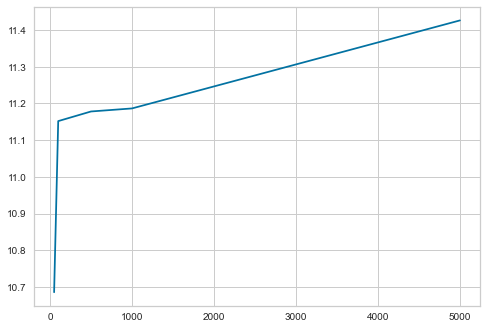

In [112]:
plt.plot([50,100,500,1000,5000],[10.685662031173706,11.151853084564209,11.178090810775757,11.186399221420288,11.426212549209595])  
plt.show() 

## Вывод  

Таким образом, сразу несколько моделей многоклассовой классификации показали хороший результат. Была построена модель нейронной сети для для разных датасетов, посчитанных в зависимости от длин последовательностей. Посчитанная метрика accuracy, время работы модели и построенный график, что время работы модели зависит прямо пропорционально от длин последовательностей, а accuracy увеличивается с ростом длины последовательности. 